# import libraries

In [242]:
import pandas as pd
import numpy as np
import os
from glob import glob
import re
from galvani import BioLogic

from function import read_mpr

import pymysql
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.widgets import Slider,CheckButtons

from scipy.signal import savgol_filter

# import raw data to MySQL

## read mpr files to pandas dataframe

In [2]:
#load data from folder
ds = read_mpr.mpr_pandas('raw_data')

In [13]:
ds[1]

,flags,Ns,time/s,dQ/mA.h,(Q-Qo)/mA.h,control/V/mA,Ewe/V,I Range,Q charge/discharge/mA.h,half cycle,loop_Nr,cycle_Nr
0,15,0,1.680460e+03,-3.409833e-10,-3.409833e-10,0.00,-0.161267,115,-3.409833e-10,0,0,1
1,15,0,1.685460e+03,0.000000e+00,-3.409833e-10,0.00,-0.161267,115,-3.409833e-10,0,0,1
2,31,0,1.690486e+03,0.000000e+00,-3.409833e-10,0.02,0.173130,117,-3.409833e-10,0,0,1
3,53,1,1.690488e+03,1.106957e-08,1.072859e-08,0.02,0.184352,117,1.072859e-08,0,0,1
4,21,1,1.695488e+03,2.772917e-05,2.773990e-05,0.02,0.867360,117,2.773990e-05,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
189758,23,1,2.191576e+06,0.000000e+00,2.462457e-01,0.00,2.056041,115,4.008953e+00,0,9,10
189759,23,1,2.191581e+06,0.000000e+00,2.462457e-01,0.00,2.056041,115,4.008953e+00,0,9,10
189760,23,1,2.191586e+06,0.000000e+00,2.462457e-01,0.00,2.056119,115,4.008953e+00,0,9,10
189761,23,1,2.191591e+06,0.000000e+00,2.462457e-01,0.00,2.055962,115,4.008953e+00,0,9,10


## add serval columns

In [3]:
# list paths of data in .mpr file
datafilespath = glob('raw_data/*.mpr') 
datafilespath =  [os.path.basename(x) for x in datafilespath]

### half cycle and state of charge

In [4]:
#set half cycle of discharge processes to 1 in gcpl
#ds[3,7,11...]
discharge_index = np.arange(3,np.shape(datafilespath)[0],4)
for index in discharge_index:
    ds[index]['half cycle']=1
#set state of charge in geis
cell_empty_index = np.arange(0,np.shape(datafilespath)[0],4)
cell_full_index = np.arange(2,np.shape(datafilespath)[0],4)
for index in cell_empty_index:
    ds[index]['state of charge']=0
for index in cell_full_index:
    ds[index]['state of charge']=1

# import dataframes to Mysql

## Structure 1:    
cell001:     
-step01_geis    
-step02_gcpl    
-step03_geis    
-step04_gcpl    

In [27]:
##structure 1
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword)
print('connection succeed')


cursor = Connection.cursor()
cursor.execute('DROP DATABASE IF EXISTS cell_configuration;')
cursor.execute('CREATE DATABASE cell_configuration;')

##cell configuration
engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db='cell_configuration', user=dbuser, pw=dbpassword))
read_mpr.filename_read(datafilespath).to_sql('cell_configuration', engine, if_exists='fail',index=False)
print('table cell_configuration created')

Cell_ID = np.unique([x.split('_')[0] for x in datafilespath])
Unique_Index = np.append(np.unique([x.split('_')[0] for x in datafilespath],return_index=True)[1],len(ds))
Tech_Type = [x.split('_')[-2].lower() for x in datafilespath]

##labor data
for i in range(len(Cell_ID)):
    cursor.execute('DROP DATABASE IF EXISTS '+Cell_ID[i])
    cursor.execute('CREATE DATABASE '+Cell_ID[i])
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=Cell_ID[i], user=dbuser, pw=dbpassword))
    step_ID = [x.split('_')[-3] for x in datafilespath]
    # capacity
    
    for j in range(Unique_Index[i],Unique_Index[i+1]):
        if step_ID[j]=='02':
            ds[j].to_sql('step'+step_ID[j]+'_'+'charge', engine, if_exists='fail',index=False)
        elif step_ID[j]=='04':
            ds[j].to_sql('step'+step_ID[j]+'_'+'discharge', engine, if_exists='fail',index=False)
        else:
            ds[j].to_sql('step'+step_ID[j]+'_'+Tech_Type[j], engine, if_exists='fail',index=False)
            
        print('table '+'step'+step_ID[j]+'_'+Tech_Type[j]+' of '+Cell_ID[i]+' created')
        
print('All data loaded')


connection succeed
table cell_configuration created
table step01_geis of Cell001 created
table step02_gcpl of Cell001 created
table step03_geis of Cell001 created
table step04_gcpl of Cell001 created
table step01_geis of Cell002 created
table step02_gcpl of Cell002 created
table step03_geis of Cell002 created
table step04_gcpl of Cell002 created
table step01_geis of Cell003 created
table step02_gcpl of Cell003 created
table step03_geis of Cell003 created
table step04_gcpl of Cell003 created
table step01_geis of Cell004 created
table step02_gcpl of Cell004 created
table step03_geis of Cell004 created
table step04_gcpl of Cell004 created
table step01_geis of Cell005 created
table step02_gcpl of Cell005 created
table step03_geis of Cell005 created
table step04_gcpl of Cell005 created
table step01_geis of Cell006 created
table step02_gcpl of Cell006 created
table step03_geis of Cell006 created
table step04_gcpl of Cell006 created
table step01_geis of Cell007 created
table step02_gcpl of Ce

## Structure 2:    
cell001:    
-geis    
-gcpl    

In [8]:
#structure 2
#We prefer this structure!
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword)
print('connection succeed')


cursor = Connection.cursor()
cursor.execute('DROP DATABASE IF EXISTS cell_configuration;')
cursor.execute('CREATE DATABASE cell_configuration;')

##cell configuration
engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db='cell_configuration', user=dbuser, pw=dbpassword))
read_mpr.filename_read(datafilespath).to_sql('cell_configuration', engine, if_exists='fail',index=False)
print('table cell_configuration created')

Cell_ID = np.unique([x.split('_')[0] for x in datafilespath])
Unique_Index = np.append(np.unique([x.split('_')[0] for x in datafilespath],return_index=True)[1],len(ds))
Tech_Type = [x.split('_')[-2].lower() for x in datafilespath]

##labor data
for i in range(len(Cell_ID)):
    cursor.execute('DROP DATABASE IF EXISTS '+Cell_ID[i])
    cursor.execute('CREATE DATABASE '+Cell_ID[i])
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=Cell_ID[i], user=dbuser, pw=dbpassword))
    step_ID = [x.split('_')[-3] for x in datafilespath]
    
    geis_data_index=[]
    for j in range(Unique_Index[i],Unique_Index[i+1]):
        if j in np.where(np.array(Tech_Type)== 'geis')[0]:
            geis_data_index = np.append(geis_data_index,j)
    geis_data = pd.concat([ds[int(k)] for k in geis_data_index],ignore_index=True)
    geis_data=geis_data.sort_values(by=['time/s'])
    geis_data.to_sql('geis', engine, if_exists='fail',index=False)
    print('geis data of '+Cell_ID[i]+ ' loaded')
    
    gcpl_data_index=[]
    for j in range(Unique_Index[i],Unique_Index[i+1]):
        
        if j in np.where(np.array(Tech_Type)== 'gcpl')[0]:
            gcpl_data_index = np.append(gcpl_data_index,j)
    gcpl_data = pd.concat([ds[int(k)] for k in gcpl_data_index],ignore_index=True)
    gcpl_data=gcpl_data.sort_values(by=['time/s'])
    gcpl_data.to_sql('gcpl', engine, if_exists='fail',index=False)    
    print('gcpl data of '+Cell_ID[i]+ ' loaded')    

        
print('All data loaded')


connection succeed
table cell_configuration created
geis data of Cell001 loaded
gcpl data of Cell001 loaded
geis data of Cell002 loaded
gcpl data of Cell002 loaded
geis data of Cell003 loaded
gcpl data of Cell003 loaded
geis data of Cell004 loaded
gcpl data of Cell004 loaded
geis data of Cell005 loaded
gcpl data of Cell005 loaded
geis data of Cell006 loaded
gcpl data of Cell006 loaded
geis data of Cell007 loaded
gcpl data of Cell007 loaded
geis data of Cell008 loaded
gcpl data of Cell008 loaded
All data loaded


# Savitzky-Golay filter

## charge/discharge curve

In [164]:
# query data from MySQL
##cell001, gcpl, structure 2
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db='cell001'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword,
                          database=db)
# structure 1
# ## charge step
# sql = 'SELECT `(Q-Qo)/mA.h`,`Ewe/V`, `time/s` from step02_charge'
# cursor = Connection.cursor()
# cursor.execute(sql)

# charge = cursor.fetchall()
# charge = np.array(charge)
# ##discharge step
# sql = 'SELECT `(Q-Qo)/mA.h`,`Ewe/V`, `time/s` from step04_discharge'
# cursor.execute(sql)

# discharge = cursor.fetchall()
# discharge = np.array(discharge)

# structue 2
sql = 'SELECT `(Q-Qo)/mA.h`,`Ewe/V`, `time/s` FROM gcpl'
cursor = Connection.cursor()
cursor.execute(sql)
curve = cursor.fetchall()
curve = np.array(curve)

<IPython.core.display.Javascript object>


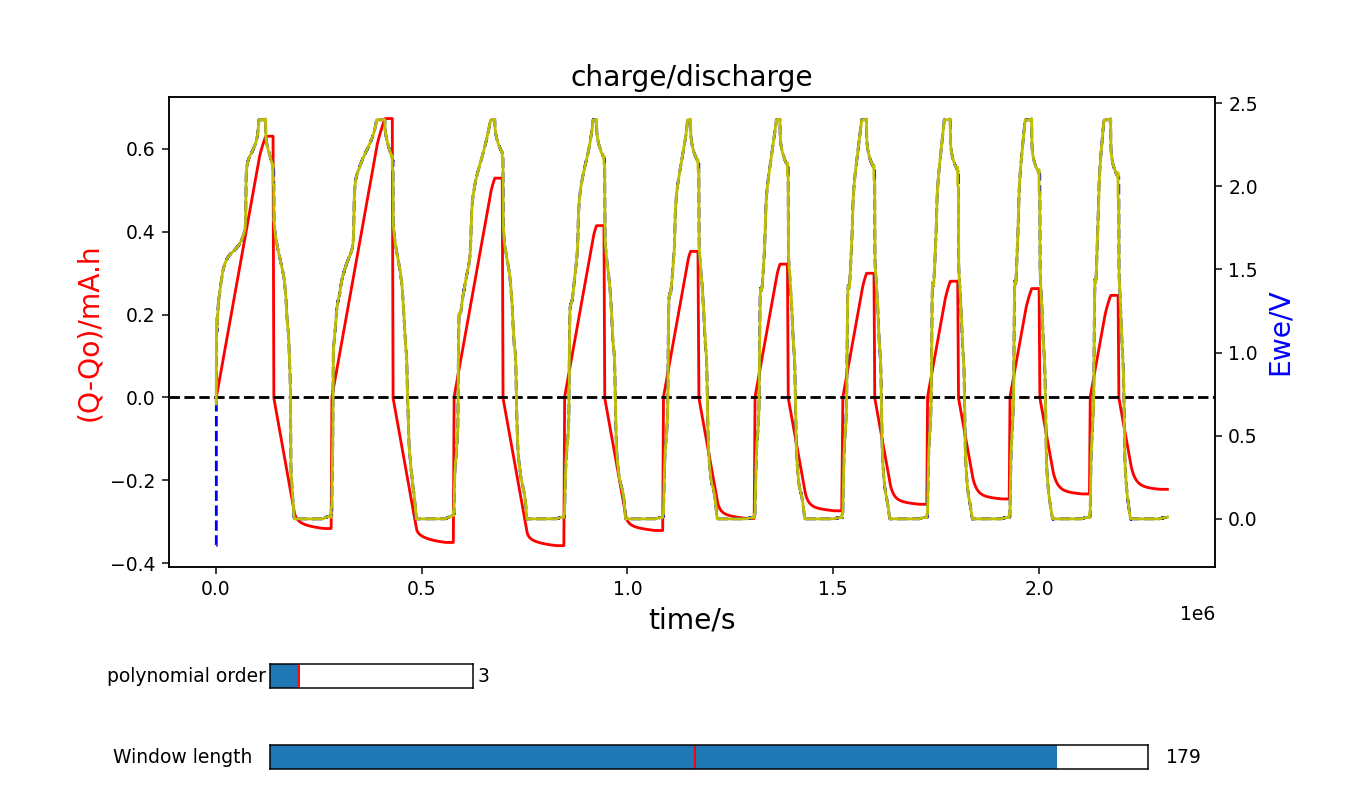

In [172]:
# curve=np.concatenate((charge,discharge))
# curve=curve[curve[:, 2].argsort()]
%matplotlib notebook
## plot curves
fig,ax = plt.subplots(figsize=(10,6))
plt.subplots_adjust(bottom=0.3)
ax.set_title('charge/discharge',fontsize=15)
ax.plot(curve[:,2], curve[:,0], color="red")
#ax.plot(charge[:,2], charge[:,0], color="red")
#ax.plot(discharge[:,2], -discharge[:,0], color="yellow")
ax.axhline(0,color='black',linestyle='--')
ax.set_xlabel("time/s",fontsize=15)
ax.set_ylabel("(Q-Qo)/mA.h",color="red",fontsize=15)

ax2=ax.twinx()
ax2.plot(curve[:,2], curve[:,1],"b--")
ax2.set_ylabel("Ewe/V",color="blue",fontsize=15)


p, = ax2.plot(curve[:,2], savgol_filter(curve[:,1],111,3), "y")

## define the slides
ax_slide1 = plt.axes([0.2,0.05,0.65,0.03])
ax_slide2 = plt.axes([0.2,0.15,0.15,0.03])

## properties of slides
win_len = Slider(ax_slide1,'Window length', valmin = 5,valmax = 199,valinit = 99,valstep = 2)
p_order = Slider(ax_slide2,'polynomial order', valmin = 2,valmax = 9,valinit = 3,valstep = 1)

## updating function
def update(val):
    current_win_len = int(win_len.val)
    current_p_order = int(p_order.val)
    p.set_ydata(savgol_filter(curve[:,1],current_win_len,current_p_order))
    fig.canvas.draw()
    
win_len.on_changed(update)
p_order.on_changed(update)

plt.show()


# cell capacity
create a table of each cell to discribe its capacity in all loops

In [189]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db=np.unique([x.split('_')[0] for x in datafilespath])

for cell in db:
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)

    sql = 'SELECT `(Q-Qo)/mA.h`,`cycle_Nr`, `half cycle` FROM ' +cell+ '.gcpl'
    cellx_df = pd.read_sql(sql, Connection)
    cycle_Nr = np.unique(cellx['cycle_Nr'])
    charge=[]
    discharge=[]
    for cycle in cycle_Nr:
        charge.append(cellx_df[(cellx_df['cycle_Nr']==cycle) & (cellx_df['half cycle']==0)]['(Q-Qo)/mA.h'].max())
        discharge.append(cellx_df[(cellx_df['cycle_Nr']==cycle) & (cellx_df['half cycle']==1)]['(Q-Qo)/mA.h'].min())
    capacity = {'cycle_Nr':cycle_Nr,'Q_charge':charge,'Q_discharge':discharge,'CE/%':np.round(np.divide(np.abs(discharge),charge)*100,2)}
    capacity = pd.DataFrame(data=capacity)
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    capacity.to_sql('capacity', engine, if_exists='replace',index=False)
    print('table capacity of '+cell +' created')

table capacity of Cell001 created
table capacity of Cell002 created
table capacity of Cell003 created
table capacity of Cell004 created
table capacity of Cell005 created
table capacity of Cell006 created
table capacity of Cell007 created
table capacity of Cell008 created


# $V$,$\frac {dV}{dt}$,$\frac{d(\frac {dV}{dt})}{dt}$ vs. time

In [224]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db=np.unique([x.split('_')[0] for x in datafilespath])
v_dV_ddV_time=[]
for cell in db:
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)

    sql = 'SELECT `Ewe/V`,`time/s` FROM ' +cell+ '.gcpl'
    cellx_df = pd.read_sql(sql, Connection)

    V = cellx_df['Ewe/V']
    #savgol_filter
    win_len = 179
    p_order = 3
    V_sg = savgol_filter(V,win_len,p_order)
    
    t =cellx_df['time/s']
    dV = np.divide(np.diff(V_sg,append=-1),np.diff(t,append=-1))
    ddV = np.divide(np.diff(dV,append=-1),np.diff(t,append=-1))
    v_dV_ddV_time = {'V':V,'V_sg':V_sg,'dV':dV,'ddV':ddV,'t':t}
    v_dV_ddV_time = pd.DataFrame(data=v_dV_ddV_time)    
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    v_dV_ddV_time.to_sql('v_dv_ddv_time', engine, if_exists='replace',index=False)
    print('table v_dv_ddv_time of '+cell +' created')

table v_dv_ddv_time of Cell001 created
table v_dv_ddv_time of Cell002 created
table v_dv_ddv_time of Cell003 created
table v_dv_ddv_time of Cell004 created
table v_dv_ddv_time of Cell005 created
table v_dv_ddv_time of Cell006 created
table v_dv_ddv_time of Cell007 created
table v_dv_ddv_time of Cell008 created


<IPython.core.display.Javascript object>


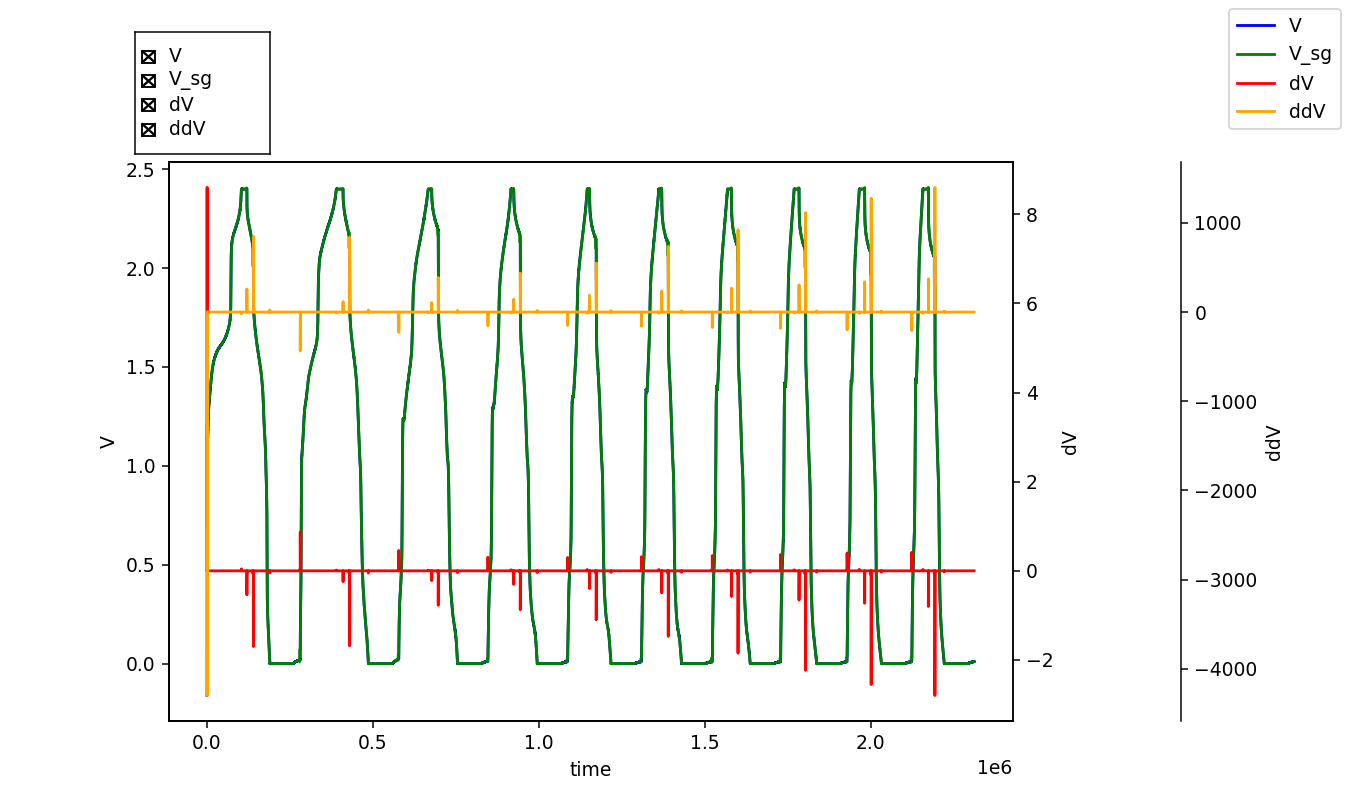

In [307]:
cell='cell001'
Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

sql = 'SELECT * FROM ' +cell+ '.v_dv_ddv_time'
cellx_df = pd.read_sql(sql, Connection)
V = cellx_df['V']
V_sg = cellx_df['V_sg']
t = cellx_df['t']
dV = cellx_df['dV']
ddV = cellx_df['ddV']

%matplotlib notebook

fig,ax = plt.subplots(figsize=(10,6))
fig.subplots_adjust(right=0.75,top=0.8)

ax2=ax.twinx()
ax3=ax.twinx()
ax3.spines.right.set_position(("axes", 1.2))
p1,=ax.plot(t,V, color="blue", label='V')
p1_sg,= ax.plot(t,V_sg, color="green", label='V_sg')
p2,=ax2.plot(t,dV, color="red", label='dV')
p3,=ax3.plot(t,ddV, color="orange", label='ddV')

ax.set_xlabel("time")
ax.set_ylabel("V")
ax2.set_ylabel("dV")
ax3.set_ylabel("ddV")

fig.legend()
## define the slides
ax_cb = plt.axes([0.1,0.81,0.1,0.15])

## properties of slides
cbs = CheckButtons(ax_cb,['V','V_sg','dV','ddV'])
cbs.set_active(0)
cbs.set_active(1)
cbs.set_active(2)
cbs.set_active(3)
## updating function
def update(val):
    status = cbs.get_status()
    p1.set_visible(status[0])
    p1_sg.set_visible(status[1])
    p2.set_visible(status[2])
    p3.set_visible(status[3])
    
    fig.canvas.draw()
    
cbs.on_clicked(update)

plt.show()


# $V$,$\frac {dV}{dQ}$,$\frac{d(\frac {dV}{dQ})}{dQ}$ vs. Q

In [211]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db=np.unique([x.split('_')[0] for x in datafilespath])
v_dV_ddV_Q=[]
for cell in db:
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)

    sql = 'SELECT `Ewe/V`,`(Q-Qo)/mA.h` FROM ' +cell+ '.gcpl'
    cellx_df = pd.read_sql(sql, Connection)

    V = cellx_df['Ewe/V']
    #savgol_filter
    win_len = 179
    p_order = 3
    V_sg = savgol_filter(V,win_len,p_order)
    
    Q =cellx_df['(Q-Qo)/mA.h']
    dV = np.divide(np.diff(V_sv,append=-1),np.diff(Q,append=-1))
    ddV = np.divide(np.diff(dV,append=-1),np.diff(Q,append=-1))
    v_dV_ddV_Q = {'V':V,'V_sg':V_sg,'dV':dV,'ddV':ddV,'Q':Q}
    v_dV_ddV_Q = pd.DataFrame(data=v_dV_ddV_Q)    
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    v_dV_ddV_Q.to_sql('v_dv_ddv_q', engine, if_exists='replace',index=False)
    print('table v_dv_ddv_q of '+cell +' created')

C:\Users\86159\AppData\Local\Temp/ipykernel_21928/669931798.py:25: RuntimeWarning: divide by zero encountered in true_divide
  dV = np.divide(np.diff(V_sv,append=-1),np.diff(Q,append=-1))


ValueError: inf cannot be used with MySQL

<IPython.core.display.Javascript object>


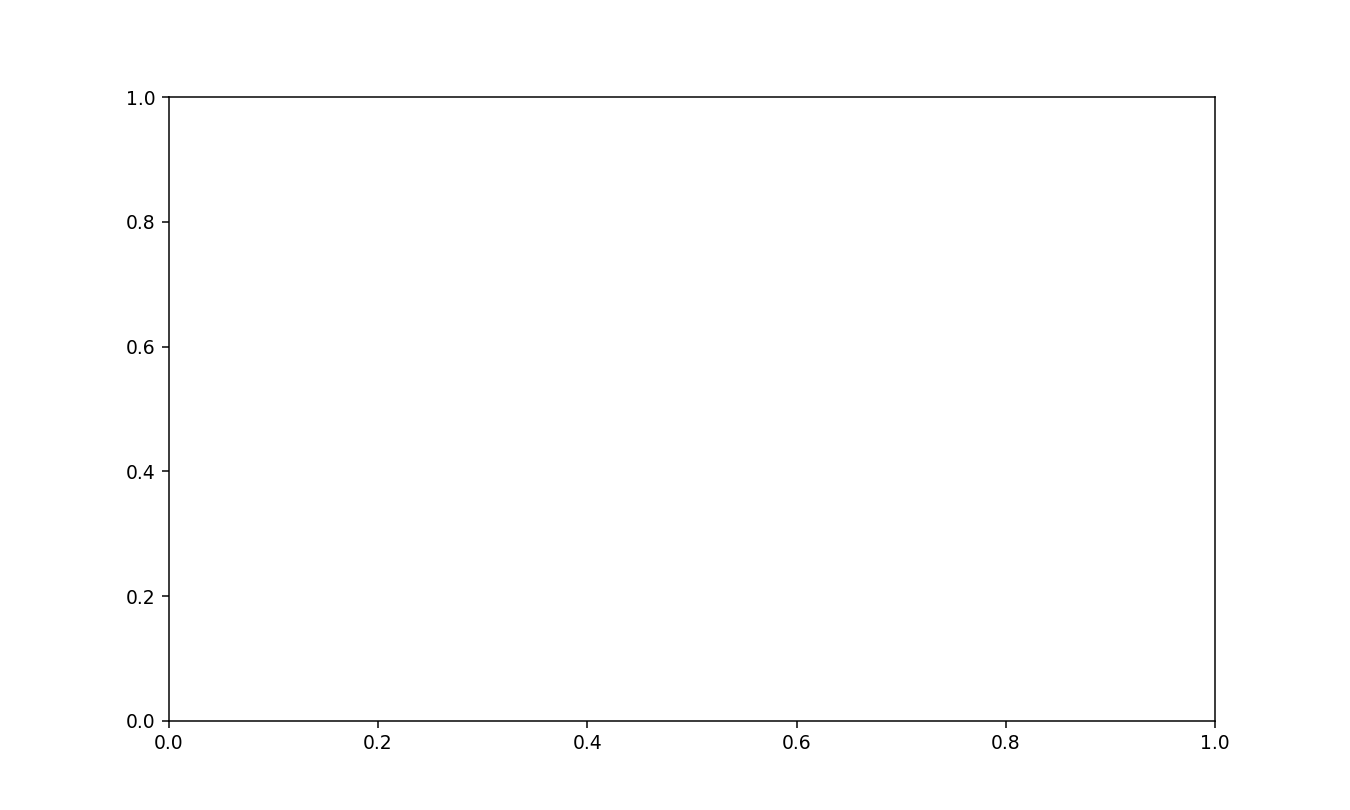

ValueError: x and y must have same first dimension, but have shapes (455458,) and (268299,)

In [282]:
fig,ax = plt.subplots(figsize=(10,6))

ax.plot(Q,V, color="red")